# Estimation of Var and CVaR Using the Discrete Moment Problem

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
def load_dataset(file_name, begin='2015-01-01', end='2022-11-01'):
    """
    Read historical price of bitcoin
    """
    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Loss'] = -np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df = df[(df.index >= begin) & (df.index <end)]
    
    return df

In [3]:
df = load_dataset(
    'BTC-USD.csv',
    begin='2017-11-01',
    end='2022-11-01')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-11-01 to 2022-10-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1826 non-null   float64
 1   High       1826 non-null   float64
 2   Low        1826 non-null   float64
 3   Close      1826 non-null   float64
 4   Adj Close  1826 non-null   float64
 5   Volume     1826 non-null   int64  
 6   Loss       1826 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 114.1 KB


In [4]:
loss = df['Loss'].dropna().sort_values().to_numpy()

In [5]:
len(loss)

1826

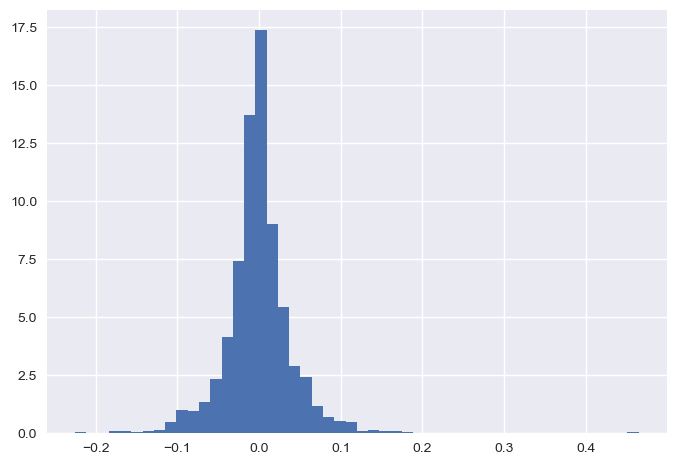

In [6]:
plt.hist(loss, bins=50, density=True)
plt.show()

## The Moment Problem

In [7]:
def mu(x, k):
    """
    Calculate the k-th moment of x
    """
    f = lambda v: v**k
    return np.mean(f(x))

In [8]:
for i in range(1, 7):
    print(f'{i}-th moment of the loss: {mu(loss, i):>15.10f}')

1-th moment of the loss:   -0.0006315936
2-th moment of the loss:    0.0016421503
3-th moment of the loss:    0.0000508860
4-th moment of the loss:    0.0000400140
5-th moment of the loss:    0.0000116499
6-th moment of the loss:    0.0000058064


In [9]:
np.std(loss)

0.04051853149927111

In [10]:
from scipy.optimize import linprog


def calc_cdf(L, m):
    """
    Return the value of c.d.f. of L at L[m]
    """
    # objective and constraint setup
    n = len(L)
    c_l = np.ones(n)
    c_u = -np.ones(n)
    A_eq = np.zeros((7, n))
    b_eq = np.zeros(7)

    for i in range(m, n):
        c_l[i] = 0
        c_u[i] = 0

    for i in range(7):
        for j in range(n):
            A_eq[i, j] = L[j]**(i)
        b_eq[i] = mu(L, i)

    # find the lower bound
    res = linprog(c_l, A_eq=A_eq, b_eq=b_eq)
    p = res.x
    f_l = res.fun

    # find the upper bound
    res = linprog(c_u, A_eq=A_eq, b_eq=b_eq)
    p = res.x
    f_u = -res.fun

    return (f_l + f_u) / 2

## Solving VaR and CVaR

In [11]:
from scipy.stats import norm


data_fact = np.sort(loss)
data_norm = np.sort(np.random.standard_normal(size=len(loss)))

x = list(range(len(loss)))
y_fact = np.zeros(len(data_fact))
y_norm = np.zeros(len(data_norm))

for i in range(len(x)):
    y_fact[i] = calc_cdf(data_fact, i)
    y_norm[i] = norm.cdf(data_norm[i])

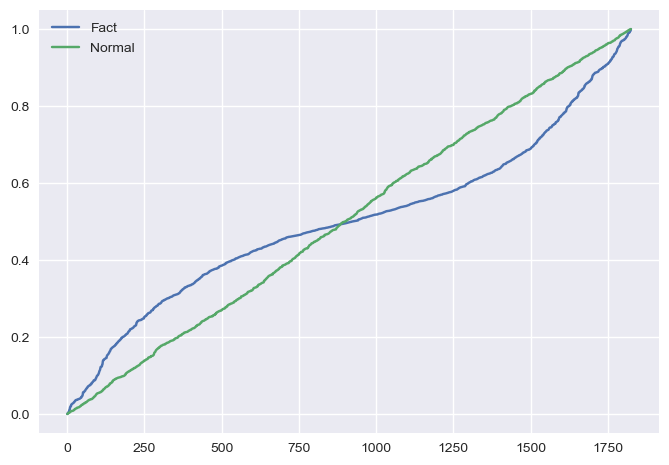

In [12]:
plt.plot(x, y_fact)
plt.plot(x, np)
plt.legend(['Fact', 'Normal'])
plt.show()

In [13]:
def calc_var(alpha, l, p):
    idx = len(l)
    while True:
        if p[idx - 1] < alpha:
            return l[idx - 1]
        idx -= 1


def calc_cvar(alpha, l, p):
    result = 0
    idx = len(l)
    while True:
        if p[idx-1] < alpha:
            return result / (1 - alpha)
        else:
            result += (p[idx-1] - p[idx-2]) * l[idx-1]
        idx -= 1


def result_summary(alpha, l, p):
    print(f'VaR with moment problem: {calc_var(alpha, l, p):>12.8f}')
    print(f'VaR with Normal dist:    {norm.ppf(alpha, loc=np.mean(l), scale=np.std(l)):>12.8f}')
    print()
    print(f'CVaR with moment problem:{calc_cvar(alpha, l, p):>12.8f}')
    print(f'CVaR with Normal dist:   {-np.mean(loss)+np.std(loss)*norm.pdf(norm.ppf(alpha))/(1-alpha):>12.8f}')    

In [14]:
result_summary(0.95, data_fact, y_fact)

VaR with moment problem:   0.08820525
VaR with Normal dist:      0.06601546

CVaR with moment problem:  0.14241746
CVaR with Normal dist:     0.08420969


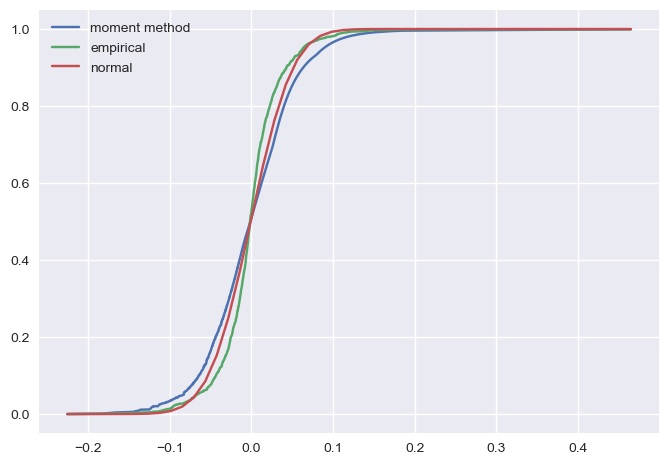

In [15]:
plt.plot(data_fact, y_fact)
plt.plot(np.sort(data_fact), np.linspace(0, 1, len(data_fact), endpoint=False))
plt.plot(
    np.linspace(np.min(data_fact), np.max(data_fact)),
    norm.cdf(np.linspace(np.min(data_fact), np.max(data_fact)),
             loc=np.mean(data_fact), scale=np.std(data_fact)))
plt.legend(['moment method', 'empirical', 'normal'])
plt.show()